In [1]:
from bs4 import BeautifulSoup
import lxml
import requests
from urllib.robotparser import RobotFileParser
from requests.compat import urlparse, urljoin
from requests.exceptions import HTTPError
from requests import request
from requests.compat import urljoin, urlparse
import time
from time import sleep
import sqlite3
import re

In [26]:
def canfetch(url, agent='*', path='/'):
    robot = RobotFileParser(urljoin(url, '/robots.txt'))
    robot.read()
    return robot.can_fetch(agent, urlparse(url)[2])
    
def download(url, params={}, headers={}, method='GET', limit=3):
    if canfetch(url) == False:
        print('[Error] ' + url)
#     else: # 실제 수집할 때, 제약사항이 많으므로 여기선 잠시 해제
    try:
        resp = request(method, url,
               params=params if method=='GET' else {},
               data=params if method=='POST' else {},
               headers=headers)
        resp.raise_for_status()
    except HTTPError as e:
        if limit > 0 and e.response.status_code >= 500:
            print(limit)
            time.sleep(1) # => random
            resp = download(url, params, headers, method, limit-1)
        else:
            print('[{}] '.format(e.response.status_code) + url)
            print(e.response.status_code)
            print(e.response.reason)
            print(e.response.headers)
    return resp

In [27]:
url = 'http://www.ppomppu.co.kr/zboard/zboard.php'
params = {
    'id' : 'ppomppu'
}
headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
}
resp = download(url, params, headers, 'GET')
dom = BeautifulSoup(resp.text, 'lxml')

In [28]:
# resp.text, dom.prettify()

In [29]:
resp.request.url

'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu'

https://validator.w3.org/unicorn/?ucn_lang=ko : 홈페이지 오류 확인

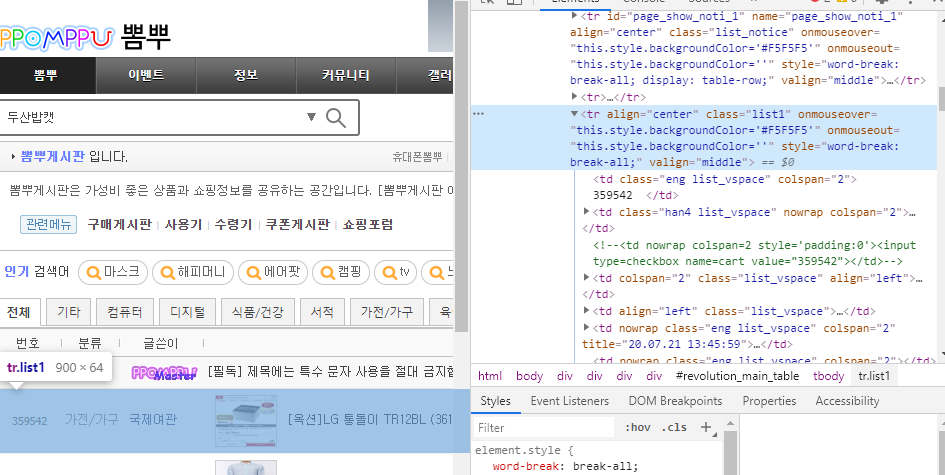

In [30]:
len(dom.select('#revolution_main_table tr[class^=list]'))

21

In [31]:
# 제일 위에 있는 제목
for _ in dom.select('#revolution_main_table tr[class^=list]'):
    print([_.text for _ in _.find_all('td')])
    break

['\n', '기타', '\xa0', '\n[필독] 제목에는 특수 문자 사용을 절대 금지합니다.- 2010년 2월 24일\n', '13/10/24', '0', '3780947']


In [32]:
for _ in dom.select('#revolution_main_table tr[class^=list]')[1:]:
    print([_.text.strip() for _ in _.find_all('td')]) # td 안에 table이 있는 구조
    print([_.find_parent().find_parent().name for _ in _.find_all('td')]) # 부모가 form 아니면 table..!!
    break
# \xa0 : euckr encoding 처리를 미처 못한부분

['359565', '의류/잡화', '부미붐', '[도매꾹]성인용 아동용 아쿠아슈즈(1800/2.500)\xa0 5', '', '[도매꾹]성인용 아동용 아쿠아슈즈(1800/2.500)\xa0 5', '16:00:28', '0 - 3', '323']
['form', 'form', 'form', 'form', 'table', 'table', 'form', 'form', 'form']


In [35]:
# 완전히 잘리진 x
for _ in dom.select('#revolution_main_table tr[class^=list]')[1:]:
    td = _.find_all('td')
    print(td[3].text.strip(), td[-2].text.strip())
#     print(td[3].text)
    print(title.findall(td[3].text))
#     break

[도매꾹]성인용 아동용 아쿠아슈즈(1800/2.500)  5 0 - 3
[('도매꾹', '성인용 아동용 아쿠아슈즈', '1800/2.500')]
[티몬] 100% 면 티셔츠 균일가 5색상 (2900/무배)  2 0 - 1
[('티몬', ' 100% 면 티셔츠 균일가 5색상 ', '2900/무배')]
[위메프][위메프데이]하이샤파 연필깎이 인기제품 모음전 (19,800~/무배)  3 
[('위메프', '[위메프데이]하이샤파 연필깎이 인기제품 모음전 ', '19,800~/무배')]
[스마트스토어] k2 비말차단마스크 kf-ad 50개입 (29,900/배송비3,000)  1 
[('스마트스토어', ' k2 비말차단마스크 kf-ad 50개입 ', '29,900/배송비3,000')]
[G마켓]  질레트 퓨전면도날 8입 (20560/무료) // 스마일클럽 화요카드 적용시  2 
[('G마켓', '  질레트 퓨전면도날 8입 ', '20560/무료')]
[위메프] 헨켈 퍼실 딥클린 파워젤, 버넬 섬유유연제 (다양/무료)  1 
[('위메프', ' 헨켈 퍼실 딥클린 파워젤, 버넬 섬유유연제 ', '다양/무료')]
[11번가] 갤럭시북 플렉스 NT930QCG-K58SA (1,749,000원 / 무배)  4 
[('11번가', ' 갤럭시북 플렉스 NT930QCG-K58SA ', '1,749,000원 / 무배')]
[스마트스토어] 국산 KF94 4중 마스크 비말차단 (970원/2800원) 766원 이벤트중 끌올  8 0 - 1
[('스마트스토어', ' 국산 KF94 4중 마스크 비말차단 ', '970원/2800원')]
[티몬] 오뚜기 삼계탕 900g 1+1 (11,610원/무배)  1 
[('티몬', ' 오뚜기 삼계탕 900g 1+1 ', '11,610원/무배')]
[큰사람모바일] 선물유심 1~2개월 통화 데이터 무제한 무료사용(0원/무료)  24 0 - 2
[('큰사람모바일', ' 선물유심 1~2개월 통화 데이터 무제한 무료사용', '0원/무료')]
[11번가][풀무원] 올바른핫

In [34]:
## 정규식으로 패턴을 찾아보자
title = re.compile(r'[[]?(\w+)[]]?([^(]+)[(](.+?)[)]')

# [[]? => (문자) 있고, 없고
#  (\w+) => 글자 1개 이상 (1)
#  []]? => (문자) 있고, 없고

# ([^(]+) => (그룹) (문자)(가 아닌 다른 문자가 1개 이상) (2)
#   [(] => (문자) ( 있고
#     (.+?) => 아무 글자나 1개 이상 (lazy) (3)
#     [)] => (문자) ) 있고

# [(1=???)] (2=?????) ((3=???))
# [LG] 통돌이 모델명 (가격)

C:\Users\USER\miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Possible nested set at position 1
  


In [36]:
# Scarping
for _ in dom.select('#revolution_main_table tr[class^=list]')[1:]:
    item = dict()
    td = _.find_all('td')
    frag1 = title.findall(td[3].text)[0]
    frag2 = td[-2].text.split('-')
    
    item['mall'] = frag1[0].strip()
    item['title'] = frag1[1].strip()
    item['price'] = frag1[2].strip()
    item['tu'] = frag2[0].strip() if len(frag2) > 1 else 0
    item['td'] = frag2[1].strip() if len(frag2) > 1 else 0
    print(item)
#     break

{'mall': '도매꾹', 'title': '성인용 아동용 아쿠아슈즈', 'price': '1800/2.500', 'tu': '0', 'td': '3'}
{'mall': '티몬', 'title': '100% 면 티셔츠 균일가 5색상', 'price': '2900/무배', 'tu': '0', 'td': '1'}
{'mall': '위메프', 'title': '[위메프데이]하이샤파 연필깎이 인기제품 모음전', 'price': '19,800~/무배', 'tu': 0, 'td': 0}
{'mall': '스마트스토어', 'title': 'k2 비말차단마스크 kf-ad 50개입', 'price': '29,900/배송비3,000', 'tu': 0, 'td': 0}
{'mall': 'G마켓', 'title': '질레트 퓨전면도날 8입', 'price': '20560/무료', 'tu': 0, 'td': 0}
{'mall': '위메프', 'title': '헨켈 퍼실 딥클린 파워젤, 버넬 섬유유연제', 'price': '다양/무료', 'tu': 0, 'td': 0}
{'mall': '11번가', 'title': '갤럭시북 플렉스 NT930QCG-K58SA', 'price': '1,749,000원 / 무배', 'tu': 0, 'td': 0}
{'mall': '스마트스토어', 'title': '국산 KF94 4중 마스크 비말차단', 'price': '970원/2800원', 'tu': '0', 'td': '1'}
{'mall': '티몬', 'title': '오뚜기 삼계탕 900g 1+1', 'price': '11,610원/무배', 'tu': 0, 'td': 0}
{'mall': '큰사람모바일', 'title': '선물유심 1~2개월 통화 데이터 무제한 무료사용', 'price': '0원/무료', 'tu': '0', 'td': '2'}
{'mall': '11번가', 'title': '[풀무원] 올바른핫도그 30개입 +[증]하인즈케첩460g', 'price': '18,040원/무료배송',

In [37]:
# crawling[링크] + Scraping[내용]
# Focused Crawling - 게시판의 파라미터로 제한

In [45]:
url = 'http://www.ppomppu.co.kr/zboard/zboard.php'

params = {
    'id':'ppomppu',
    'page':1
}
headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
}

In [46]:

# for page in range(1,10):
#     params['page'] = page
#     resp = download(url, params, headers, 'GET')
#     dom = BeautifulSoup(resp.text, 'lxml')
    
#     # Scraping
#     for _ in dom.select('#revolution_main_table tr[class^=list]')[1:]:
#         item = dict()
#         td = _.find_all('td', recursive=False) # 자식 요소만 가지고 오게 recursive opt
#         temp = title.findall(td[3].text)
#         frag1 = temp[0] if len(temp) > 0 else td[3].text.strip(0)
#         frag2 = td[-2].text.split('-')

#         item['mall'] = frag1[0].strip()
#         item['title'] = frag1[1].strip()
#         item['price'] = frag1[2].strip()
#         item['tu'] = frag2[0].strip() if len(frag2) > 1 else 0
#         item['td'] = frag2[1].strip() if len(frag2) > 1 else 0
#         print(item)
        
    
    
    

In [47]:
url = 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu'

headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
}

urls = list()
seen = list() # 방문했었는지

urls.append(url)


while urls: # Queue
    seed = urls.pop(0) # starting url
    seen.append(seed) # 재방문 회피
    
    dom = BeautifulSoup(download(seed).text, 'lxml')
    
    for _ in [_['href'] 
              for _ in dom.select('''
              tr.list0 a[href], tr.list0 a[href], #page_list a[href]
              ''') ## src에 내장이 되어있는 형식 대처
              if re.match(r'(?:https?:/)?/\w+(?:[./]\w+)+', _['href'])]:
        
        newUrls = urljoin(seed, _)
        if newUrls not in urls \
        and newUrls not in seen:
            urls.append(newUrls)
    print(len(urls), len(seen))

10 1
10 2
9 3
8 4
7 5
6 6
5 7
4 8
3 9
2 10
11 11
10 12
9 13
8 14
7 15
6 16
5 17
4 18
3 19
2 20
1 21
10 22
9 23
8 24
7 25
6 26
5 27
4 28
3 29
2 30
1 31
10 32
9 33
8 34
7 35
6 36
5 37
4 38
3 39
2 40
1 41
10 42
9 43
8 44
7 45
6 46
5 47
4 48
3 49
2 50
1 51
10 52
9 53
8 54
7 55
6 56
5 57


KeyboardInterrupt: 

In [48]:
seen

['http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=2&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=3&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=4&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=5&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=6&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=7&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=8&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=9&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=10&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=11&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=1&divpage=62',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=ppomppu&page=12&divpage=62',
 'http://www.ppomppu.co.kr/

In [86]:
url = 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1'

params = {
    'id':'freeboard',
    'page':1
}
headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
}

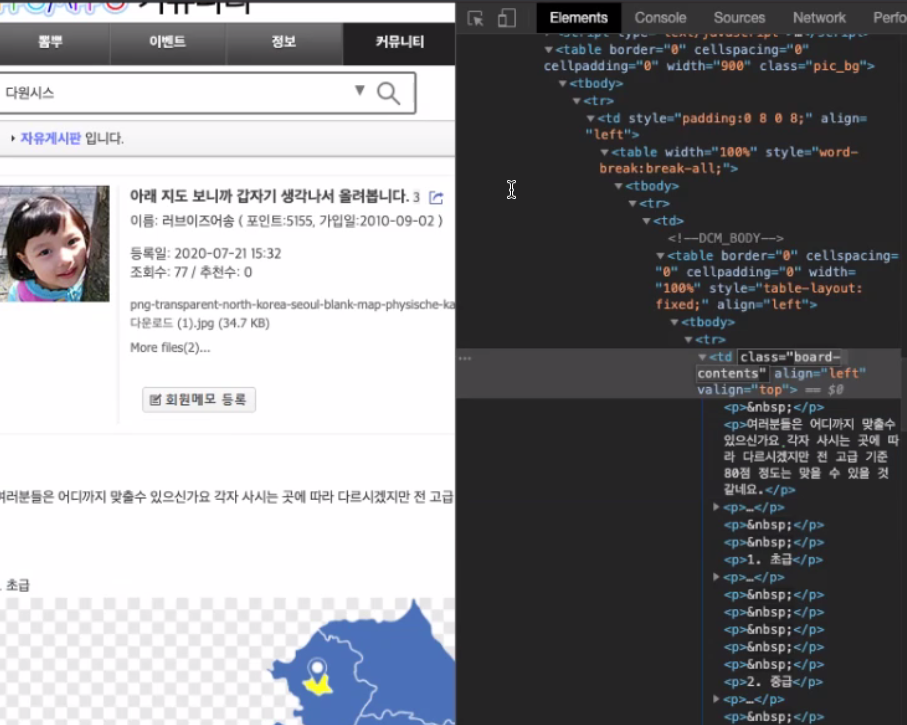

In [87]:
# !pip list
# get_ipython().system('pip install --upgrade lxml')

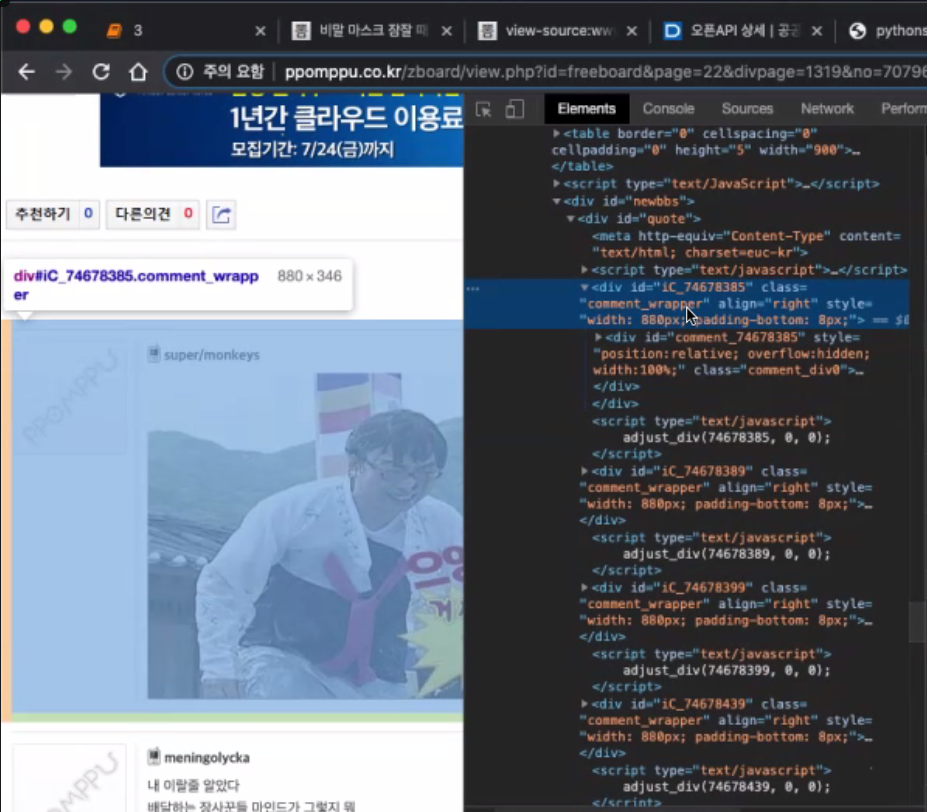

In [107]:
## 글 가져오기

urls = list()
seen = list()

urls.append({'url':url, 'depth':1})

while urls:
    seed = urls.pop(0)
    seen.append(seed)
    
    if seed['depth'] > 3:
        break
        
    resp = download(seed['url'])
    dom = BeautifulSoup(resp.text, 'lxml')
    
    for _ in dom.select('''
        .list0 > td:nth-of-type(3) a,
        .list1 > td:nth-of-type(3) a,
        #page_list a'''): ## 문제 구간
        if _['href'][0] in ['v', '/']:
            newurl = urljoin(url, _['href'])
            if newurl not in [_['url'] for _ in urls] and\
               newurl not in [_['url'] for _ in seen]:
                urls.append({'url':newurl,
                             'depth':seed['depth']+1})
            # 여기까지가 크롤링
            
            # 여기서부터가 스크래핑
            if dom.select_one('.board-contents') != None:
                print(
                    {'head':dom.select_one('.view_title2').text.strip(),
                       'body':dom.select_one('.board-contents').text.strip(),
                       'comments':[_.text.strip() 
                                   for _ in dom.select('.comment_wrapper')]}
                )
                print()
            if seed['depth'] > 1 :
                break

## 10 page 까지 가져오기 - page list 밑에
                    
# resp = download(url, params, headers)
# dom = BeautifulSoup(resp.text, 'lxml')
# for _ in dom.select('#page_list a'):
#     if _['href'].startswith('/'):
#         print(urljoin(url, _['href']))
#         resp = download(urljoin(url, _['href']))
#         dom = BeautifulSoup(resp.text, 'lxml')
#         if dom.select_one('.board-contents') != None:
#             print(dom.select_one('.board-contents').name)
#     print(_.text.strip())

In [108]:
seen

[{'url': 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1',
  'depth': 1},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080386',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080385',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080384',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080383',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080382',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080381',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080380',
  'depth': 2},
 {'url': 'http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&page=1&divpage=1319&no=7080379',
  'depth': 2},
 {'url': 'http

In [111]:
resp = download(seed['url'])
dom = BeautifulSoup(resp.text, 'lxml')
dom.select('.board-contents')
# dom.select('table.pic_bg table table > tr > td:nth-of-type(1)')

[<td align="left" class="board-contents" valign="top">
 실생활에서 대화하면서 친구끼리 사흘후에 보자 라고 안하잖아요 삼일뒤에 보자고하죠
 <p> </p>
 <p>전 웹소설 많이 보는편인데 글에서는 하루 이틀 나흘 나흘 이라는 표현이 꽤 나옵니다.</p>
 <p> </p>
 <p>초딩때 다 배우는건데도 착각하기 쉬운편이고</p>
 <p> </p>
 <p>학교에서 공부할때도 책에 나왔겠지만 사흘 이라는 단어를 보고 그냥 4일이라고 생각하면서 살았겠죠..ㄷㄷ</p>
 <p> </p>
 <p>대부분 보긴하지만 뜻을 오해하면서 지낸 것 같아요</p><!--"&lt;--></td>]

In [79]:
dom

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html lang="ko" xml:lang="ko" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="text/javascript" http-equiv="Content-Script-Type"/>
<meta content="text/css" http-equiv="Content-Style-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0, user-scalable=yes, target-densitydpi=device-dpi" name="viewport"/>
<meta content="뽐뿌" property="og:site_name"/>
<meta content="article" property="og:type"/>
<meta content="http://www.ppomppu.co.kr/zboard/view.php?id=freeboard&amp;no=7080307" property="og:url"/>
<meta content="프로페시아 글 보니 저도 7년동안 복용 중이네요 ㄷㄷ7년 전과 현재" property="og:title"/>
<meta content="2012년부터 이상하게 빠지더라구요.. 당시 20대 중반 ㅠ너무 기르면 앞머리가 엄청 비어" property="og:description"/>
<meta content="https://cdn.ppomppu.co.kr/zboard

In [106]:
[_.name for _ in dom.select('.list0 > td:nth-of-type(3) > a')]

[]